<a href="https://colab.research.google.com/github/vhrique/ELF/blob/main/01_Improved_SciBERT_MiniBatchKMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE
from transformers import AutoModel, AutoTokenizer

In [2]:
url = 'https://drive.google.com/uc?export=download&id=1LacuZm4G4L-FtBIIKXnOTwr99cw0onl6'

response = requests.get(url)

if response.status_code == 200:
    text_content = response.text
else:
    print(f"Failed to retrieve the file. Status code: {response.status_code}")

In [3]:
all_lines = text_content.splitlines()

entry = {}
entries = []
for i, line in enumerate(all_lines):
    if line == '':
        entries.append(entry)
        entry = {}
        continue
    values = line.split('- ')
    value = '- '.join(values[1:])
    key = values[0].strip()
    if key == 'DO':
        entry['DO'] = value
    if key == 'AB':
        entry['AB'] = value
    if key == 'KW':
        if 'KW' not in entry:
            entry['KW'] = []
        entry['KW'].append(value)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased").to(device)

In [21]:
def get_encodings(entry, max_length=512):

    abstract = entry['AB'].lower()
    keywords = [kw.lower() for kw in entry['KW']]

    abstract_tokens = tokenizer([f'abstract: {abstract}\n'], return_tensors="pt").input_ids
    input_token = torch.tensor([abstract_tokens[0][0]])
    end_token = torch.tensor([abstract_tokens[0][-1]])
    abstract_tokens = abstract_tokens[0][1:-1]
    keywords_tokens = [tokenizer([f'keyword: {keyword}\n'], return_tensors="pt").input_ids[0,1:-1] for keyword in keywords]
    input_tensors = torch.concat([input_token] + keywords_tokens + [abstract_tokens] + [end_token], dim=0)
    if len(input_tensors) >= max_length:
        input_tensors = torch.concat([input_tensors[:max_length-1]] + [end_token], dim=0)

    with torch.no_grad():
        model_outputs = model(input_tensors.unsqueeze(0).to(device))
        embeddings = model_outputs.last_hidden_state

    start = 1
    end = 1
    keywords_embeddings = []
    for keyword in keywords_tokens:
        start = end
        end = min(max_length-1, start + keyword.shape[0])
        keywords_embeddings.append(embeddings[0][start:end].mean(axis=0))
        if end == max_length-1:
            break

    start = end
    abstract_embedding = embeddings[0][start:-1].mean(axis=0)
    # abstract_embedding = model_outputs.pooler_output[0]


    return abstract_embedding, keywords_embeddings

_ = get_encodings(entries[2])

In [22]:
embeddings = []
text = []
text_type = []
doi = []
indices = []

for i, entry in tqdm(enumerate(entries), total=len(entries)):

    if 'DO' not in entry or 'KW' not in entry:
        continue

    abstract_embedding, keywords_embeddings = get_encodings(entry)

    embeddings.append(abstract_embedding.tolist())
    text.append(entry['AB'])
    text_type.append('abstract')
    doi.append(entry['DO'])
    indices.append(i)

    for keyword, keyword_embeddings in zip(entry['KW'], keywords_embeddings):
        embeddings.append(keyword_embeddings.tolist())
        text.append(keyword)
        text_type.append('keyword')
        doi.append(entry['DO'])
        indices.append(i)


df = pd.DataFrame({
    'entries': indices,
    'doi': doi,
    'type': text_type,
    'text': text,
    'emb': embeddings
})
# df.to_csv('abstract_keyword_embeddings.csv', index=False)

100%|██████████| 898/898 [00:22<00:00, 39.40it/s]


In [23]:
isna = np.isnan(np.array(embeddings)).sum(axis=1) > 0
df = df.loc[~isna]

In [24]:
X2d = TSNE(n_components=2).fit_transform(np.array(df.emb.tolist()))

In [25]:
df['tsne1'] = X2d[:,0]
df['tsne2'] = X2d[:,1]

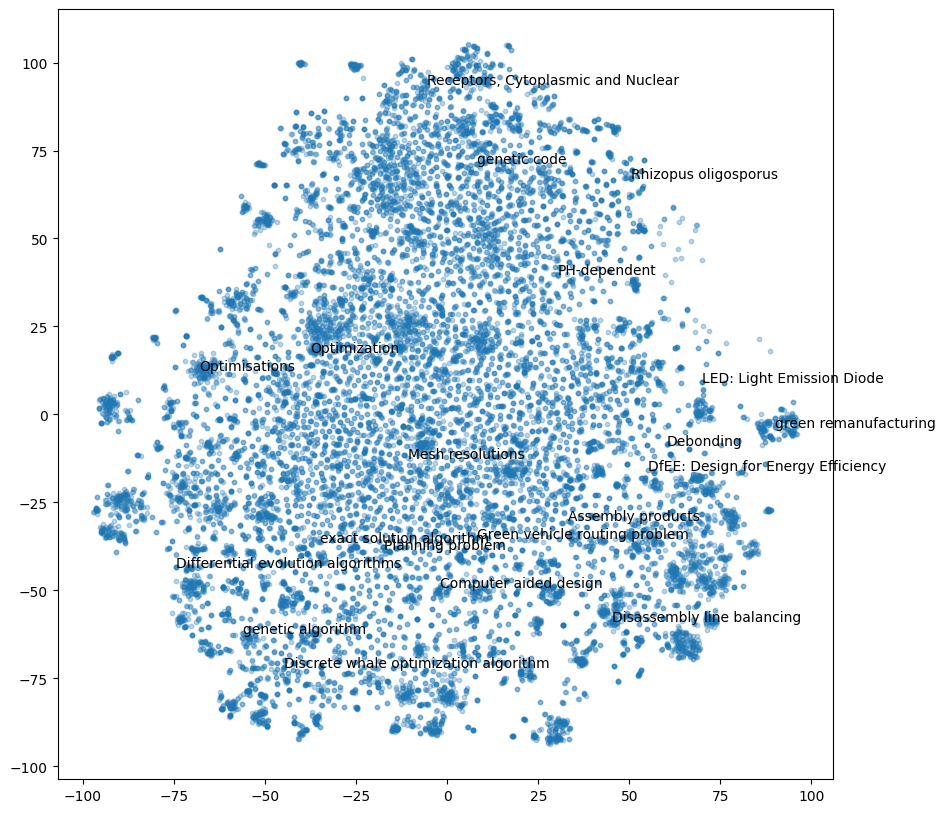

In [26]:
plt.figure(figsize=(10,10))
plt.scatter(df.query('type=="keyword"').tsne1, df.query('type=="keyword"').tsne2, s=10, alpha=0.3)
for _ in range(20):
    row = df.query('type=="keyword"').sample(1).iloc[0]
    plt.text(row.tsne1, row.tsne2, row.text)
plt.show()

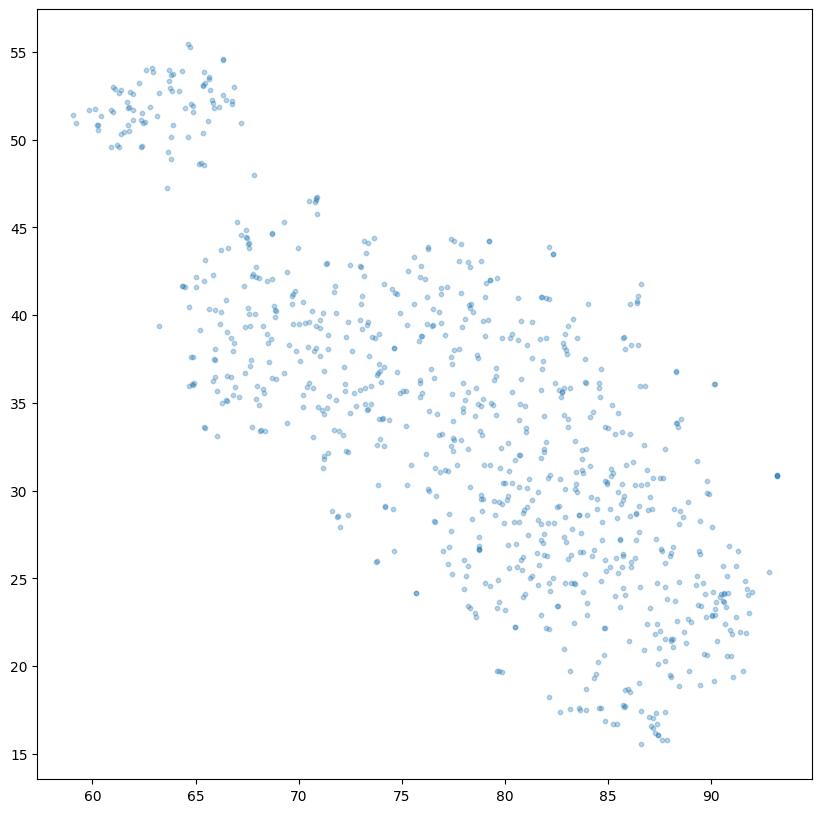

In [27]:
plt.figure(figsize=(10,10))
plt.scatter(df.query('type=="abstract"').tsne1, df.query('type=="abstract"').tsne2, s=10, alpha=0.3)
plt.show()

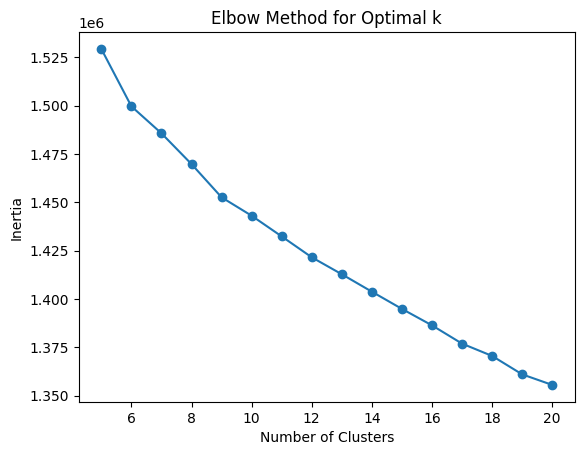

7 ['shape memory effect', 'chance-constrained programming', 'modular design', 'dissolved gas analysis', 'Recycle']
13 ['racemization', 'Generic strategies', 'Condyloma acuminatum', 'Bounding box', 'Electrochemical sensors']
4 ['Press fits', 'Battery recycling', 'Bucket brigades', 'Bicycle frames', 'Bearings (machine parts)']
14 ['Linear programming models', 'Stochastic models', 'Lagrangian decomposition', 'Constrained optimization', 'Learning systems']
6 ['Safety engineering', 'Production control', 'Tools', 'Geometrical calibrations', 'Partial distributions']
5 ['Electricity costs', 'Influence diagram', 'Facilities layout', 'Structure activity relationships', 'Variable demands']
0 ['Remanufacturing system', 'Multi agent systems', 'Supply chain operation', 'Steel beams', 'Vibrio natriegens']
12 ['Genomics', 'genome', 'Manufacture', 'rapeseed solar', 'Robotics']
10 ['Self-adaptive parameter control', 'Generative adversarial networks', 'Augmented reality (AR)', 'Ant colony algorithms', 'P

<ipython-input-28-896d0f21c0a5>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_keyword.loc[:,'cluster'] = clusters


In [28]:
def find_optimal_clusters(X, min_k=5, max_k=20, plot=True):
    inertias = []
    for k in range(min_k, max_k+1):
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)

    if plot:
        plt.plot(range(min_k, max_k+1), inertias, marker='o')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Inertia')
        plt.title('Elbow Method for Optimal k')
        plt.show()

    # Use "elbow" heuristic to pick optimal k (or default to 3)
    diffs = np.diff(inertias)
    optimal_k = np.argmin(diffs[1:] - diffs[:-1]) + min_k if len(diffs) > 1 else 1

    final_kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=0)
    clusters = final_kmeans.fit_predict(X)
    return optimal_k, clusters

df_keyword = df.query('type == "keyword"')
optimal_k, clusters = find_optimal_clusters(np.array(df_keyword.emb.tolist()))

df_keyword.loc[:,'cluster'] = clusters

for cluster in df_keyword.cluster.unique():
    print(cluster, df_keyword.query(f'cluster == {cluster}').sample(5).text.tolist())

In [29]:
kmeans = MiniBatchKMeans(n_clusters=40, random_state=0)
clusters = kmeans.fit_predict(np.array(df_keyword.emb.tolist()))
df_keyword.loc[:,'cluster'] = clusters
for cluster in df_keyword.cluster.unique():
    print(cluster, df_keyword.query(f'cluster == {cluster}').sample(10).text.tolist())

6 ['Genetic programming', 'Electrochemical impedance spectroscopy', 'MILP model', 'Reinforcement learning', 'Design challenges', 'stochastic optimisation', 'Optimal solution path', 'Design/methodology/approach', 'Combinatorial optimization', 'Artificial intelligence optimization']
38 ['Bill of materials', 'End-of-life vehicles', 'Destabilization', 'Deep learning', 'Reverse supply chain', 'microrobot', 'Microphone channel', 'autonomous assembly', 'fast feasible solution generator', 'supply chain management']
4 ['Self assembled nanostructures', 'Interlocking signals', 'Anisotropic colloids', 'Functional components', 'Seals', 'Chinese Hamster ovary cells', 'Complex manufacturing systems', 'Electrochemical sensors', 'Collaborative robots', 'Complex products']
15 ['Optimal systems', 'Stochastic models', 'Design Principles', 'Mathematical models', 'Stochastic simulations', 'Stochastic models', 'Petri nets', 'Gaussians', 'Directed graphs', 'Dimension vectors']
16 ['Sustainable development', '